# Train MLModel

In [82]:
import numpy as np
import pandas as pd

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 84, Finished, Available)

In [83]:
# Load test data
test = spark.sql("SELECT * FROM Silver.test")
test.show(5)

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 85, Finished, Available)

+-----------+---------+----------+----------+-----------+--------+--------+------------+---------+
|OverallQual|GrLivArea|GarageCars|GarageArea|TotalBsmtSF|1stFlrSF|FullBath|TotRmsAbvGrd|YearBuilt|
+-----------+---------+----------+----------+-----------+--------+--------+------------+---------+
|          8|     1418|       3.0|     852.0|     1642.0|    1418|       1|           6|     2010|
|          4|     1362|       3.0|     768.0|     1040.0|    1362|       1|           6|     1957|
|          6|     1521|       3.0|     640.0|      741.0|     780|       1|           8|     1910|
|          5|     1072|       5.0|    1184.0|     1072.0|    1072|       1|           5|     1925|
|          9|     1680|       3.0|    1138.0|     1555.0|    1680|       1|           8|     2009|
+-----------+---------+----------+----------+-----------+--------+--------+------------+---------+
only showing top 5 rows



In [84]:
display(test, summary=True)

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 86, Finished, Available)

SynapseWidget(Synapse.DataFrame, 8b530f3a-42e1-4e9c-a9ed-27980321bc55)

In [85]:
# Load train data
train = spark.sql("SELECT * FROM Silver.train")
train.show(5)

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 87, Finished, Available)

+---------+-----------+---------+----------+----------+-----------+--------+--------+------------+---------+
|SalePrice|OverallQual|GrLivArea|GarageCars|GarageArea|TotalBsmtSF|1stFlrSF|FullBath|TotRmsAbvGrd|YearBuilt|
+---------+-----------+---------+----------+----------+-----------+--------+--------+------------+---------+
|   206300|          7|     1344|         4|       784|       1344|    1344|       2|           8|     1997|
|   265979|          7|     2640|         4|       864|       1240|    1320|       1|           8|     1880|
|   168000|          4|     1622|         4|      1356|       1249|    1622|       1|           7|     1961|
|   123000|          4|      872|         4|       480|        858|     872|       1|           5|     1971|
|   200000|          5|     2634|         4|       968|       1248|    1338|       2|          12|     1969|
+---------+-----------+---------+----------+----------+-----------+--------+--------+------------+---------+
only showing top 5 

In [86]:
display(train, summary=True)

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 88, Finished, Available)

SynapseWidget(Synapse.DataFrame, c1d78538-df17-4bd7-8ff3-f3136d055351)

In [87]:
print((train.count(), len(train.columns)))
print((test.count(), len(test.columns)))

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 89, Finished, Available)

(1458, 10)
(1459, 9)


In [88]:
train = train.toPandas()
test = test.toPandas()
train.head(3)

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 90, Finished, Available)

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt
0,206300,7,1344,4,784,1344,1344,2,8,1997
1,265979,7,2640,4,864,1240,1320,1,8,1880
2,168000,4,1622,4,1356,1249,1622,1,7,1961


In [89]:
print(train.shape)
print(test.shape)

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 91, Finished, Available)

(1458, 10)
(1459, 9)


In [90]:
df1 = test[test.isna().any(axis=1)]
df1

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 92, Finished, Available)

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt
272,4,896,1.0,280.0,NaN,896,1,4,1946
668,5,1828,NaN,NaN,859.0,942,2,6,1923


In [91]:
print(test.shape)
test.dropna(how='any', inplace=True)
print(test.shape)

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 93, Finished, Available)

(1459, 9)
(1457, 9)


In [92]:
df1 = train[train.isna().any(axis=1)]
df1

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 94, Finished, Available)

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt


In [93]:
y_train = train.SalePrice.values
#train.drop(['SalePrice'], axis=1, inplace=True)
#train.head(3) 

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 95, Finished, Available)

In [94]:
print(train.shape)
print(test.shape)

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 96, Finished, Available)

(1458, 10)
(1457, 9)


In [95]:
def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(train)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 97, Finished, Available)

1028 examples in training, 430 examples in testing.


In [96]:
!pip install tensorflow_decision_forests -U -qq
import tensorflow as tf
import tensorflow_decision_forests as tfdf

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 98, Finished, Available)

In [97]:
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 99, Finished, Available)

In [98]:
tfdf.keras.get_all_models()

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 100, Finished, Available)

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [99]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"]) # Optional, you can use this to include a list of eval metrics

gb = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION)
gb.compile(metrics=["mse"]) # Optional, you can use this to include a list of eval metrics

cart = tfdf.keras.CartModel(task = tfdf.keras.Task.REGRESSION)
cart.compile(metrics=["mse"]) # Optional, you can use this to include a list of eval metrics

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 101, Finished, Available)

Use /tmp/tmp1725h2fd as temporary training directory
Use /tmp/tmpb2o012pk as temporary training directory
Use /tmp/tmpzvl9buyp as temporary training directory


[WARNING 23-08-03 13:21:32.7384 UTC gradient_boosted_trees.cc:1818] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-03 13:21:32.7384 UTC gradient_boosted_trees.cc:1829] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-03 13:21:32.7384 UTC gradient_boosted_trees.cc:1843] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


In [100]:
rf.fit(x=train_ds)
gb.fit(x=train_ds)
cart.fit(x=train_ds)

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 102, Finished, Available)

Reading training dataset...
Training dataset read in 0:00:00.152291. Found 1028 examples.
Training model...
Model trained in 0:00:00.354608
Compiling model...
Model compiled.
Reading training dataset...
5 out of the last 5 calls to <function CoreModel._consumes_training_examples_until_eof at 0x7fd519adba30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Training dataset read in 0:00:00.144429. Found 1028 examples.
Training model...
Model trained in 0:00:00.149297
Compiling mo

[INFO 23-08-03 13:21:34.0010 UTC kernel.cc:1243] Loading model from path /tmp/tmp1725h2fd/model/ with prefix 71f3cddfb3e94a69
[INFO 23-08-03 13:21:34.1291 UTC decision_forest.cc:660] Model loaded with 300 root(s), 97136 node(s), and 9 input feature(s).
[INFO 23-08-03 13:21:34.1291 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-08-03 13:21:34.1291 UTC kernel.cc:1075] Use fast generic engine
[INFO 23-08-03 13:21:34.5639 UTC kernel.cc:1243] Loading model from path /tmp/tmpb2o012pk/model/ with prefix d2231790074f4c80
[INFO 23-08-03 13:21:34.5673 UTC kernel.cc:1075] Use fast generic engine
[INFO 23-08-03 13:21:34.8813 UTC kernel.cc:1243] Loading model from path /tmp/tmpzvl9buyp/model/ with prefix 028e9d839b384e89
[INFO 23-08-03 13:21:34.8817 UTC decision_forest.cc:660] Model loaded with 1 root(s), 111 node(s), and 8 input feature(s).
[INFO 23-08-03 13:21:34.8817 UTC kernel.cc:1075] Use fast generic engine


In [101]:
print(rf.summary())

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 103, Finished, Available)

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (9):
	1stFlrSF
	FullBath
	GarageArea
	GarageCars
	GrLivArea
	OverallQual
	TotRmsAbvGrd
	TotalBsmtSF
	YearBuilt

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.  "OverallQual"  0.341439 ################
    2.    "GrLivArea"  0.306448 #############
    3.    "YearBuilt"  0.169677 ####
    4.  "TotalBsmtSF"  0.167821 ###
    5.   "GarageCars"  0.164338 ###
    6.   "GarageArea"  0.154472 ##
    7.     "1stFlrSF"  0.149119 ##
    8.     "FullBath"  0.115634 
    9. "TotRmsAbvGrd"  0.111772 

Variable Importance: NUM_AS_ROOT:
    1. "OverallQual" 125.000000 ################
    2.   "GrLi

In [102]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 104, Finished, Available)

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 105, Finished, Available)

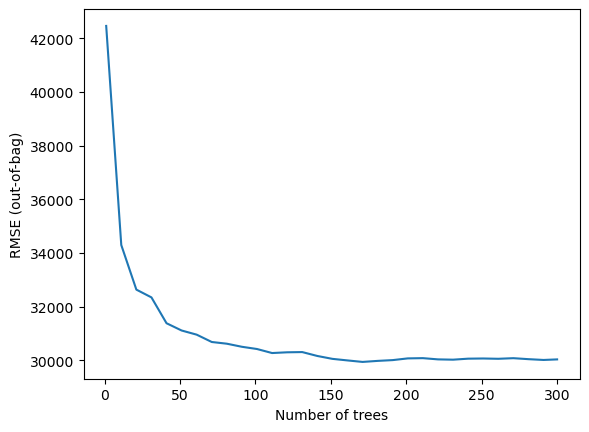

In [103]:
import matplotlib.pyplot as plt
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [105]:
evaluation_rf = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation_rf.items():
  print(f"{name}: {value:.4f}")


StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 107, Finished, Available)

1/1 [==============================] - 0s 59ms/step - loss: 0.0000e+00 - mse: 922211648.0000
loss: 0.0000
mse: 922211648.0000


In [106]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, task = tfdf.keras.Task.REGRESSION)

rf_prediction = rf.predict(x=test_ds)
errors = abs(rf_prediction[:,0] - valid_ds_pd['SalePrice'].values)
MSE=round(np.mean(errors),2)
MAPE=100*(errors/valid_ds_pd['SalePrice'].values)
accuracy=round (100 - np.mean(MAPE),2)
print(f"Rf prediction accuracy: {accuracy}")

gb_prediction = gb.predict(x=test_ds)
errors = abs(gb_prediction[:,0] - valid_ds_pd['SalePrice'].values)
MSE=round(np.mean(errors),2)
MAPE=100*(errors/valid_ds_pd['SalePrice'].values)
accuracy=round (100 - np.mean(MAPE),2)
print(f"Gb prediction accuracy: {accuracy}")

cart_prediction = cart.predict(x=test_ds)
errors = abs(cart_prediction[:,0] - valid_ds_pd['SalePrice'].values)
MSE=round(np.mean(errors),2)
MAPE=100*(errors/valid_ds_pd['SalePrice'].values)
accuracy=round (100 - np.mean(MAPE),2)
print(f"Gb prediction accuracy: {accuracy}")

output_table = valid_ds_pd.copy()
output_table['rf_prediction'] = rf_prediction
output_table['gb_prediction'] = gb_prediction
output_table['cart_prediction'] = cart_prediction
output_table
output_table = spark.createDataFrame(output_table)
output_table.write.format("delta").mode('overwrite').save("abfss://HousingPrices@onelake.dfs.fabric.microsoft.com/Gold.Lakehouse/Tables/tfkeras_training")

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 108, Finished, Available)

1/1 [==============================] - 0s 79ms/step
Rf prediction accuracy: 88.96
1/1 [==============================] - 0s 72ms/step
Gb prediction accuracy: 88.67
1/1 [==============================] - 0s 70ms/step
Gb prediction accuracy: 84.75


/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


In [107]:
np.sqrt(evaluation_rf['mse'])

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 109, Finished, Available)

30367.937829230355

In [109]:
inspector = rf.make_inspector()
inspector.evaluation()
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 111, Finished, Available)

Available variable importances:
	 NUM_NODES
	 NUM_AS_ROOT
	 SUM_SCORE
	 INV_MEAN_MIN_DEPTH


In [110]:
inspector.variable_importances()["NUM_AS_ROOT"]

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 112, Finished, Available)

[("OverallQual" (1; #5), 125.0),
 ("GrLivArea" (1; #4), 74.0),
 ("GarageCars" (1; #3), 65.0),
 ("GarageArea" (1; #2), 17.0),
 ("YearBuilt" (1; #8), 16.0),
 ("TotalBsmtSF" (1; #7), 2.0),
 ("FullBath" (1; #1), 1.0)]

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 113, Finished, Available)

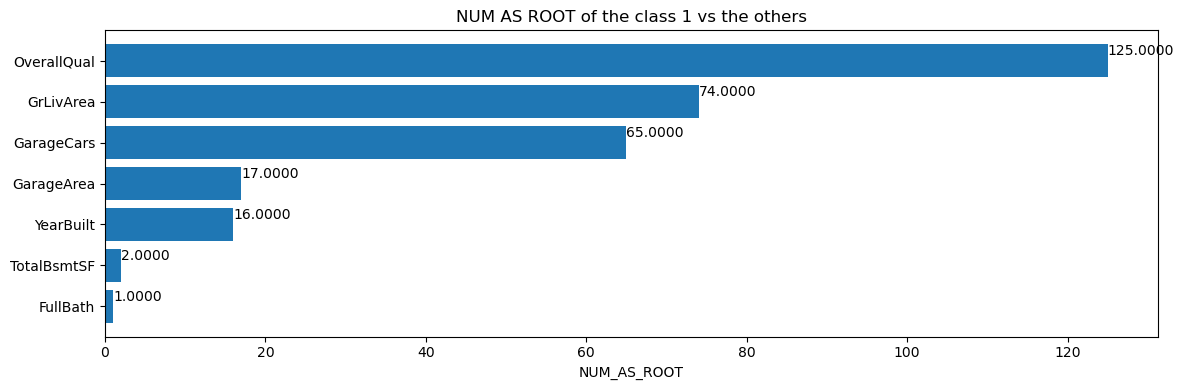

In [111]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

# Predict

In [118]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, task = tfdf.keras.Task.REGRESSION)
# RF
rf_preds = rf.predict(test_ds)
# GB
gb_preds = gb.predict(test_ds)
# Cart
cart_preds = cart.predict(test_ds)

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 120, Finished, Available)

2/2 [==============================] - 0s 3ms/step


In [119]:
print(f"Number of tests: {test.shape}")
print(f"Number of predictions: {rf_preds.shape}")

predicted_sale_prices_output = test.copy()
predicted_sale_prices_output['PredictedSalePriceRF'] = rf_preds
predicted_sale_prices_output['PredictedSalePriceGB'] = gb_preds
predicted_sale_prices_output['PredictedSalePriceCart'] = cart_preds

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 121, Finished, Available)

Number of tests: (1457, 9)
Number of predictions: (1457, 1)


In [120]:
predicted_sale_prices_output

StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 122, Finished, Available)

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,PredictedSalePriceRF,PredictedSalePriceGB,PredictedSalePriceCart
0,8,1418,3.0,852.0,1642.0,1418,1,6,2010,249089.250000,268956.468750,182372.875000
1,4,1362,3.0,768.0,1040.0,1362,1,6,1957,139336.796875,133158.718750,147825.515625
2,6,1521,3.0,640.0,741.0,780,1,8,1910,159369.968750,155886.515625,131370.437500
3,5,1072,5.0,1184.0,1072.0,1072,1,5,1925,125850.562500,118432.117188,101230.000000
4,9,1680,3.0,1138.0,1555.0,1680,1,8,2009,316913.718750,327049.718750,322809.312500
...,...,...,...,...,...,...,...,...,...,...,...,...
1454,7,1594,2.0,434.0,846.0,846,2,7,2004,188731.203125,186243.859375,182372.875000
1455,7,1374,2.0,400.0,384.0,744,2,7,2004,163362.953125,163212.828125,182372.875000
1456,7,1548,2.0,388.0,1365.0,1548,2,7,2004,200535.968750,200733.796875,226342.640625
1457,7,1598,2.0,433.0,848.0,848,2,7,2004,188701.437500,186243.859375,182372.875000


In [122]:
train_table = spark.createDataFrame(train)
prediction_table = spark.createDataFrame(predicted_sale_prices_output)
train_table.write.format("delta").mode('overwrite').save("abfss://HousingPrices@onelake.dfs.fabric.microsoft.com/Gold.Lakehouse/Tables/train")
prediction_table.write.format("delta").mode('overwrite').save("abfss://HousingPrices@onelake.dfs.fabric.microsoft.com/Gold.Lakehouse/Tables/tfkeras_prediction")


StatementMeta(, 3dc588e4-547a-4617-a35d-270defd6014c, 124, Finished, Available)